# HPO: Hyper-parameter Optimization

- 목적
    - UCI 데이터셋을 로드하고 전처리 후 LightGBM 모델을 구축 및 평가
    - 교차검증(StratifiedKFold, KFold)과 하이퍼파라미터 탐색 기법(RandomizedSearchCV, Optuna)을 비교하여 최적 성능 도출
- 구현
    - 데이터 로드: UCI Bank Marketing 데이터
    - 데이터 전처리: 범주형 인코딩, 타겟(y) 이진화, StandardScaler로 범위 스케일링
    - 모델 구축: LGBMClassifier
    - 모델 평가: 정확도, AUC, 분류리포트, 혼동행렬, feature importance
    - 교차검증: 교차검증: KFold, StratifiedKFold
    - 하이퍼파라미터 최적화: Random Search, Optuna TPE

In [ ]:
#  UCI Machine Learning Data Load Library
!pip install ucimlrepo

In [ ]:
#  Bayesian Search Library
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.4 MB/s eta 0:00:00


In [ ]:
#  Bayesian Search(TPE) Library
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 9.8 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import time
import xgboost as xgb


## 1. Data Load

In [ ]:
from ucimlrepo import fetch_ucirepo

def load_data():

    # fetch dataset
    bank_marketing = fetch_ucirepo(id=222)

    # data (as pandas dataframes)
    X = bank_marketing.data.features
    y = bank_marketing.data.targets

    # Concatenate
    df = pd.concat([X, y], axis=1)

    print(f"Shape: {df.shape}")
    print(f"Info: {df.info()}")
    print(f"Samples: {df.head(5)}")
    print("Bank Marketing Dataset load")

    return df, X, y

# 1.데이터 로드
df, X, y = load_data()

Shape: (45211, 17)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None
Samples:
   age           job  

## 2. EDA

In [ ]:
def eda_data(df):

    # 기본 통계
    print("데이터 타입:")
    print(df.dtypes)

    print("\n결측치 확인:")
    print(df.isnull().sum())

    print("\n타겟 변수 분포:")
    target_counts = df['y'].value_counts()
    print(target_counts)
    print(f"비율: {target_counts / len(df) * 100}")

    print("\n숫자형 변수 기본 통계:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(df[numeric_cols].describe())

    print("\n범주형 변수 고유값 개수:")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        print(f"{col}: {df[col].nunique()}개 고유값")
        if df[col].nunique() <= 10:  # 고유값이 적으면 분포 출력
            print(df[col].value_counts().head())
        print()

# 2.데이터 탐색
eda_data(df)

데이터 타입:
age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

결측치 확인:
age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64

타겟 변수 분포:
y
no     39922
yes     5289
Name: count, dtype: int64
비율: y
no     88.30152
yes    11.69848
Name: count, dtype: float64

숫자형 변수 기본 통계:
                age        balance   day_of_week      duration      campaign  \

## 3. Pre-processing

In [ ]:
def preprocess_data(X, y):

    # 데이터프레임 복사
    X_processed = X.copy()

    # 범주형 변수들을 레이블 인코딩
    categorical_columns = X_processed.select_dtypes(include=['object']).columns
    label_encoders = {}

    for col in categorical_columns:
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_processed[col].astype(str))
        label_encoders[col] = le
        print(f"{col} 인코딩 완료: {len(le.classes_)}개 클래스")

    # 타겟 변수 인코딩 (yes=1, no=0)
    y_processed = (y['y'] == 'yes').astype(int)

    print(f"타겟 분포: {y_processed.value_counts().to_dict()}")

    return X_processed, y_processed, label_encoders


# 3. 데이터 전처리
X_processed, y_processed, label_encoders = preprocess_data(X, y)

job 인코딩 완료: 12개 클래스
marital 인코딩 완료: 3개 클래스
education 인코딩 완료: 4개 클래스
default 인코딩 완료: 2개 클래스
housing 인코딩 완료: 2개 클래스
loan 인코딩 완료: 2개 클래스
contact 인코딩 완료: 3개 클래스
month 인코딩 완료: 12개 클래스
poutcome 인코딩 완료: 4개 클래스
타겟 분포: {0: 39922, 1: 5289}


In [ ]:
label_encoders

{'job': LabelEncoder(),
 'marital': LabelEncoder(),
 'education': LabelEncoder(),
 'default': LabelEncoder(),
 'housing': LabelEncoder(),
 'loan': LabelEncoder(),
 'contact': LabelEncoder(),
 'month': LabelEncoder(),
 'poutcome': LabelEncoder()}

## 4. Baseline Modeling & Evaluation

In [ ]:
def build_and_evaluate_model(X, y):
    """XGBoost 모델 구축 및 평가"""
    print("\n=== XGBoost 모델 구축 및 평가 ===")

    # 훈련/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"훈련 데이터: {X_train.shape}")
    print(f"테스트 데이터: {X_test.shape}")

    # 특성 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # XGBoost 모델 훈련
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        early_stopping_rounds=5,
        eval_metric='logloss'
    )

    print("XGBoost Learning...")
    xgb_model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=False
    )

    # 예측
    y_pred = xgb_model.predict(X_test_scaled)
    y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

    # 평가
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(f"\n정확도: {accuracy:.4f}")
    print(f"AUC 점수: {auc_score:.4f}")

    print("\n분류 리포트:")
    print(classification_report(y_test, y_pred))

    print("\n혼동 행렬:")
    print(confusion_matrix(y_test, y_pred))

    # 특성 중요도
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n상위 10개 중요한 특성:")
    print(feature_importance.head(10))

    return xgb_model, scaler, feature_importance

# 4. 모델 구축 및 평가
model, scaler, feature_importance = build_and_evaluate_model(X_processed, y_processed)



=== XGBoost 모델 구축 및 평가 ===
훈련 데이터: (36168, 16)
테스트 데이터: (9043, 16)
XGBoost Learning...

정확도: 0.9103
AUC 점수: 0.9314

분류 리포트:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.67      0.45      0.54      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.71      0.75      9043
weighted avg       0.90      0.91      0.90      9043


혼동 행렬:
[[7752  233]
 [ 578  480]]

상위 10개 중요한 특성:
        feature  importance
15     poutcome    0.333886
11     duration    0.180560
6       housing    0.101092
8       contact    0.088195
10        month    0.055407
7          loan    0.037297
13        pdays    0.031768
0           age    0.026959
12     campaign    0.023817
9   day_of_week    0.023566


## 5. Cross-Validation Method

In [ ]:
def compare_cv_strategies(X, y):
    """다양한 CV 전략 비교"""
    from sklearn.model_selection import KFold, RepeatedStratifiedKFold

    print("\n=== Cross-Validation 전략 비교 ===")

    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 모델
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )

    # CV 전략들
    cv_strategies = {
    #    'Leave-One-Out (LOOCV)': LeaveOneOut(),
        'KFold (5-fold)': KFold(n_splits=5, shuffle=True, random_state=42),
        'StratifiedKFold (5-fold)': StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        'StratifiedKFold (20-fold)': StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
    }

    results = {}
    for name, cv_strategy in cv_strategies.items():
        scores = cross_val_score(xgb_model, X_scaled, y, cv=cv_strategy, scoring='roc_auc', n_jobs=-1)
        results[name] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
        print(f"{name}: {scores.mean():.4f} (±{scores.std()*2:.4f})")

    return results


results = compare_cv_strategies(X_processed, y_processed)


=== Cross-Validation 전략 비교 ===
KFold (5-fold): 0.9330 (±0.0046)
StratifiedKFold (5-fold): 0.9333 (±0.0083)
StratifiedKFold (20-fold): 0.9341 (±0.0104)


## 6-1. HPO: Grid Search

In [ ]:
def grid_search_tuning_cv(X, y):
    """Cross-Validation을 활용한 그리드 서치 하이퍼파라미터 튜닝"""
    from sklearn.model_selection import GridSearchCV
    print("\n=== 하이퍼파라미터 튜닝 (GridSearchCV) ===")
    t0 = time.perf_counter()

    # 파라미터 그리드 정의
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }

    # XGBoost 모델
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        eval_metric='logloss'
    )

    # GridSearchCV 설정
    grid_search = GridSearchCV(
        estimator=xgb_model,     # 최적화를 적용할 모델
        param_grid=param_grid,   # 탐색할 하이퍼파라미터 공간
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,               # 병렬 실행 스레드 수, -1 = CPU 전체 사용
        verbose=1
    )

    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 그리드 서치 실행
    print("GridSearchCV 실행 중...")
    grid_search.fit(X_scaled, y)

    dt = time.perf_counter() - t0
    print(f"수행 시간: {dt:.3f}s")
    print(f"최적 파라미터: {grid_search.best_params_}")
    print(f"최적 CV 점수: {grid_search.best_score_:.4f}")


    return grid_search.best_estimator_, scaler


best_estimator_, scaler = grid_search_tuning_cv(X_processed, y_processed)



=== 하이퍼파라미터 튜닝 (GridSearchCV) ===
Fitting 5 folds for each of 81 candidates, totalling 405 fits
수행 시간: 230.157s
최적 파라미터: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
최적 CV 점수: 0.9350


## 6-2. HPO: Random Search

In [ ]:
def random_search_tuning(X, y):
    """Cross-Validation을 활용한 랜덤 서치 하이퍼파라미터 튜닝"""
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import uniform, randint

    t0 = time.perf_counter()

    print("\n=== 하이퍼파라미터 튜닝 (RandomizedSearchCV) ===")

    # 랜덤 서치를 위한 파라미터 분포 정의
    param_distributions = {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
      #  'colsample_bytree': uniform(0.6, 0.4),
    }

    # XGBoost 모델
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        eval_metric='logloss'
    )

    # RandomizedSearchCV 설정
    random_search = RandomizedSearchCV(
        estimator=xgb_model,      # 최적화를 적용할 모델
        param_distributions=param_distributions,  # 탐색할 하이퍼파라미터 분포
        n_iter=50,               # 탐색할 반복 횟수
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,                # 병렬 실행 스레드 수, -1 = CPU 전체 사용
        verbose=1,
        random_state=42
    )

    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 랜덤 서치 실행
    print("RandomizedSearchCV 실행 중...")
    random_search.fit(X_scaled, y)

    dt = time.perf_counter() - t0
    print(f"수행 시간: {dt:.3f}s")
    print(f"최적 파라미터: {random_search.best_params_}")
    print(f"최적 CV 점수: {random_search.best_score_:.4f}")

    # 상위 5개 결과 출력
    print("\n상위 5개 파라미터 조합:")
    results_df = pd.DataFrame(random_search.cv_results_)
    top_5 = results_df.nlargest(5, 'mean_test_score')[['mean_test_score', 'std_test_score', 'params']]

    for idx, (_, row) in enumerate(top_5.iterrows(), 1):
        print(f"{idx}. 점수: {row['mean_test_score']:.4f} (±{row['std_test_score']*2:.4f})")
        print(f"   파라미터: {row['params']}")

    return random_search.best_estimator_, scaler, random_search

best_estimator_, scaler, random_search = random_search_tuning(X_processed, y_processed)



=== 하이퍼파라미터 튜닝 (RandomizedSearchCV) ===
RandomizedSearchCV 실행 중... (시간이 걸릴 수 있습니다)
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


수행 시간: 229.898s
최적 파라미터: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05}
최적 CV 점수: 0.9350

상위 5개 파라미터 조합:
1. 점수: 0.9350 (±0.0070)
   파라미터: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05}
2. 점수: 0.9349 (±0.0083)
   파라미터: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}
3. 점수: 0.9348 (±0.0075)
   파라미터: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05}
4. 점수: 0.9348 (±0.0077)
   파라미터: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05}
5. 점수: 0.9347 (±0.0072)
   파라미터: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05}


## 6-3. HPO: Bayesian Search

In [ ]:
def bayesian_search_tuning(X, y):
    """베이지안 최적화를 활용한 하이퍼파라미터 튜닝"""
    t0 = time.perf_counter()

    from skopt import BayesSearchCV
    from skopt.space import Real, Integer, Categorical

    print("\n=== 하이퍼파라미터 튜닝 (Bayesian Optimization) ===")

    # 베이지안 최적화를 위한 검색 공간 정의
    # log-uniform 분포: 작은 값 쪽에 더 많은 샘플을 할당 → 학습률은 보통 작은 값이 성능에 큰 영향을 주기 때문에 로그 분포로 탐색하는 게 효율적
    search_space = {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(4, 8),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'subsample': Real(0.8, 1.0)
    }


    # XGBoost 모델
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        eval_metric='logloss'
    )

    # BayesSearchCV 설정
    bayes_search = BayesSearchCV(
        estimator=xgb_model,          # 최적화를 적용할 모델
        search_spaces=search_space,   # 탐색할 하이퍼파라미터 공간 (딕셔너리 형식)
        n_iter=30,                    # 탐색할 반복 횟수(기본값:50), 클수록 더 좋은 해를 찾을 확률이 높지만 시간이 오래 걸림, 30~100
        scoring='roc_auc',            # 평가지표
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,                    # 병렬 실행 스레드 수, -1 = CPU 전체 사용
        random_state=42,
        verbose=0                     # 출력 로그 레벨(0 = 없음, 1 이상 = 진행 상황 출력)
    )

    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 베이지안 최적화 실행
    print("Bayesian Optimization 실행 중...")
    bayes_search.fit(X_scaled, y)

    dt = time.perf_counter() - t0
    print(f"수행 시간: {dt:.3f}s")

    print(f"최적 파라미터: {bayes_search.best_params_}")
    print(f"최적 CV 점수: {bayes_search.best_score_:.4f}")

    # 최적화 과정 분석
    print(f"\n최적화 과정 분석:")
    print(f"전체 시도 횟수: {len(bayes_search.cv_results_['mean_test_score'])}")

    # 상위 5개 결과 출력
    print("\n상위 5개 파라미터 조합:")
    results_df = pd.DataFrame(bayes_search.cv_results_)
    top_5 = results_df.nlargest(5, 'mean_test_score')[['mean_test_score', 'std_test_score', 'params']]

    for idx, (_, row) in enumerate(top_5.iterrows(), 1):
        print(f"{idx}. 점수: {row['mean_test_score']:.4f} (±{row['std_test_score']*2:.4f})")
        print(f"   파라미터: {row['params']}")

    # 수렴 곡선 데이터 생성
    scores_over_time = []
    best_score_so_far = -np.inf
    for score in bayes_search.cv_results_['mean_test_score']:
        if score > best_score_so_far:
            best_score_so_far = score
        scores_over_time.append(best_score_so_far)

    print(f"\n수렴 분석:")
    print(f"초기 10회 평균 점수: {np.mean(scores_over_time[:10]):.4f}")
    print(f"마지막 10회 최고 점수: {scores_over_time[-1]:.4f}")
    print(f"개선 정도: {(scores_over_time[-1] - np.mean(scores_over_time[:10])):.4f}")

    return bayes_search.best_estimator_, scaler, bayes_search

best_estimator_, scaler, bayes_search = bayesian_search_tuning(X_processed, y_processed)



=== 하이퍼파라미터 튜닝 (Bayesian Optimization) ===
Bayesian Optimization 실행 중...
수행 시간: 133.782s
최적 파라미터: OrderedDict({'learning_rate': 0.08331735534504574, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.8})
최적 CV 점수: 0.9350

최적화 과정 분석:
전체 시도 횟수: 30

상위 5개 파라미터 조합:
1. 점수: 0.9350 (±0.0074)
   파라미터: OrderedDict({'learning_rate': 0.08331735534504574, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.8})
2. 점수: 0.9350 (±0.0079)
   파라미터: OrderedDict({'learning_rate': 0.07110294782765374, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8})
3. 점수: 0.9350 (±0.0077)
   파라미터: OrderedDict({'learning_rate': 0.07730425163251096, 'max_depth': 7, 'n_estimators': 143, 'subsample': 0.8})
4. 점수: 0.9342 (±0.0080)
   파라미터: OrderedDict({'learning_rate': 0.040343472274915984, 'max_depth': 7, 'n_estimators': 190, 'subsample': 0.8631599186974098})
5. 점수: 0.9342 (±0.0069)
   파라미터: OrderedDict({'learning_rate': 0.15849201309311142, 'max_depth': 5, 'n_estimators': 140, 'subsample': 0.9605529562312621})

수렴 분

## 6-4. HPO: Bayesian Search(TPE:Tree-structured Parzen Estimator) using Optuna

In [ ]:
import optuna

def optuna_search_tuning(X, y, n_trials=100):
    """Optuna를 활용한 하이퍼파라미터 튜닝"""
    t0 = time.perf_counter()

    print("\n=== 하이퍼파라미터 튜닝 (Optuna) ===")

    # 전역 변수로 데이터를 저장 (objective 함수에서 사용하기 위해)
    global X_train_global, X_val_global, y_train_global, y_val_global, scaler_global

    # 데이터 분할 및 스케일링
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # 전역 변수에 할당
    X_train_global, X_val_global = X_train_scaled, X_val_scaled
    y_train_global, y_val_global = y_train, y_val
    scaler_global = scaler

    def objective(trial):
        """Optuna objective 함수"""

        # 하이퍼파라미터 제안
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'random_state': 42,
            'verbosity': 0,

            # 튜닝할 하이퍼파라미터들
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.8, 1.0)
               }

        # XGBoost 모델 생성 및 훈련
        model = xgb.XGBClassifier(**params)

        model.fit(
            X_train_global, y_train_global,
            eval_set=[(X_val_global, y_val_global)],
            verbose=False
        )

        # 검증 성능 계산
        y_pred_proba = model.predict_proba(X_val_global)[:, 1]
        auc_score = roc_auc_score(y_val_global, y_pred_proba)

        return auc_score

    # Optuna 스터디 생성
    print(f"Optuna 최적화 시작 ({n_trials}회 시도)...")

    # 로그 출력 줄이기
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
    )

    # 최적화 실행
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # 결과 출력
    dt = time.perf_counter() - t0
    print(f"수행 시간: {dt:.3f}s")
    print(f"최적 AUC 점수: {study.best_value:.4f}")
    print(f"최적 파라미터: {study.best_params}")
    print(f"시도 횟수: {len(study.trials)}")

    # 최적 모델 재훈련
    best_params = study.best_params.copy()
    best_params.update({
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42
    })

    best_model = xgb.XGBClassifier(**best_params)
    best_model.fit(X_train_global, y_train_global)

    # 최적화 과정 분석
    print(f"\n=== 최적화 과정 분석 ===")

    # 상위 5개 시도 결과
    best_trials = sorted(study.trials, key=lambda t: t.value if t.value else -np.inf, reverse=True)[:5]
    print("상위 5개 시도 결과:")
    for i, trial in enumerate(best_trials, 1):
        if trial.value:
            print(f"{i}. AUC: {trial.value:.4f}, 파라미터: {trial.params}")

    # 수렴 분석
    values = [trial.value for trial in study.trials if trial.value is not None]
    if len(values) >= 10:
        early_avg = np.mean(values[:len(values)//2])
        late_avg = np.mean(values[len(values)//2:])
        print(f"\n수렴 분석:")
        print(f"전반부 평균 AUC: {early_avg:.4f}")
        print(f"후반부 평균 AUC: {late_avg:.4f}")
        print(f"개선 정도: {late_avg - early_avg:.4f}")

    # 파라미터 중요도 분석
    importance = optuna.importance.get_param_importances(study)
    print(f"\n파라미터 중요도 (Top 5):")
    for param, imp in sorted(importance.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {param}: {imp:.4f}")

    return best_model, scaler_global, study

best_model, scaler_global, study = optuna_search_tuning(X_processed, y_processed, n_trials=30)


=== 하이퍼파라미터 튜닝 (Optuna) ===
Optuna 최적화 시작 (30회 시도)...


  0%|          | 0/30 [00:00<?, ?it/s]

수행 시간: 19.112s
최적 AUC 점수: 0.9329
최적 파라미터: {'n_estimators': 131, 'max_depth': 6, 'learning_rate': 0.09613607895787614, 'subsample': 0.8267555018998413}
시도 횟수: 30

=== 최적화 과정 분석 ===
상위 5개 시도 결과:
1. AUC: 0.9329, 파라미터: {'n_estimators': 131, 'max_depth': 6, 'learning_rate': 0.09613607895787614, 'subsample': 0.8267555018998413}
2. AUC: 0.9326, 파라미터: {'n_estimators': 181, 'max_depth': 5, 'learning_rate': 0.10389590734703245, 'subsample': 0.8466381460165087}
3. AUC: 0.9324, 파라미터: {'n_estimators': 185, 'max_depth': 5, 'learning_rate': 0.08929285641219858, 'subsample': 0.8120531855928077}
4. AUC: 0.9323, 파라미터: {'n_estimators': 196, 'max_depth': 5, 'learning_rate': 0.053566770906231354, 'subsample': 0.8017372221127864}
5. AUC: 0.9323, 파라미터: {'n_estimators': 195, 'max_depth': 5, 'learning_rate': 0.07704669005072709, 'subsample': 0.802358795884076}

수렴 분석:
전반부 평균 AUC: 0.9237
후반부 평균 AUC: 0.9303
개선 정도: 0.0065

파라미터 중요도 (Top 5):
  learning_rate: 0.4072
  subsample: 0.3679
  n_estimators: 0.2029
  max_

## Task1: 위 예시 사례를 활용하고 적용모델을 달리하여 하이퍼 파라메타 최적화(HPO) 수행  
 - HPO Method 중 2개의 Method를 선정하여 비교분석 해보세요.
 - 적용 모델을 다르게.. (XGBoost 제외)

In [ ]:
# ==============================
# LightGBM 기반 HPO 실습
# ==============================

!pip install lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from ucimlrepo import fetch_ucirepo
from lightgbm import LGBMClassifier

import optuna
from sklearn.model_selection import RandomizedSearchCV

# 1. 데이터 로드
def load_data():
    bank_marketing = fetch_ucirepo(id=222)
    X = bank_marketing.data.features
    y = bank_marketing.data.targets
    df = pd.concat([X, y], axis=1)
    print(f"Shape: {df.shape}")
    print(f"Info: {df.info()}")
    print(f"Samples: {df.head(5)}")
    return df, X, y

df, X, y = load_data()

# 2. 데이터 전처리
def preprocess_data(X, y):
    X_processed = X.copy()
    categorical_columns = X_processed.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_processed[col].astype(str))
        label_encoders[col] = le
        print(f"{col} 인코딩 완료: {len(le.classes_)}개 클래스")
    y_processed = (y['y'] == 'yes').astype(int)
    print(f"타겟 분포: {y_processed.value_counts().to_dict()}")
    return X_processed, y_processed, label_encoders

X_processed, y_processed, label_encoders = preprocess_data(X, y)

# 3. 모델 구축 및 평가
def build_and_evaluate_model(X, y):
    print("\n=== LightGBM 모델 구축 및 평가 ===")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lgbm_model = LGBMClassifier(
        n_estimators=100,
        max_depth=-1,
        learning_rate=0.1,
        random_state=42
    )

    lgbm_model.fit(X_train_scaled, y_train)
    y_pred = lgbm_model.predict(X_test_scaled)
    y_pred_proba = lgbm_model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"\n정확도: {accuracy:.4f}")
    print(f"AUC 점수: {auc_score:.4f}")
    print("\n분류 리포트:")
    print(classification_report(y_test, y_pred))
    print("\n혼동 행렬:")
    print(confusion_matrix(y_test, y_pred))

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': lgbm_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print("\n상위 10개 중요한 특성:")
    print(feature_importance.head(10))

    return lgbm_model, scaler, feature_importance

model, scaler, feature_importance = build_and_evaluate_model(X_processed, y_processed)

# 4. 교차검증 전략 비교
def compare_cv_strategies(X, y):
    print("\n=== Cross-Validation 전략 비교 ===")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lgbm_model = LGBMClassifier(
        n_estimators=100,
        max_depth=-1,
        learning_rate=0.1,
        random_state=42
    )
    cv_strategies = {
        'KFold (5-fold)': KFold(n_splits=5, shuffle=True, random_state=42),
        'StratifiedKFold (5-fold)': StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    }
    results = {}
    for name, cv_strategy in cv_strategies.items():
        scores = cross_val_score(lgbm_model, X_scaled, y, cv=cv_strategy, scoring='roc_auc', n_jobs=-1)
        results[name] = {'mean': scores.mean(), 'std': scores.std(), 'scores': scores}
        print(f"{name}: {scores.mean():.4f} (±{scores.std()*2:.4f})")
    return results

results = compare_cv_strategies(X_processed, y_processed)

# 5. HPO (Random Search)
def random_search_tuning(X, y):
    print("\n=== 하이퍼파라미터 튜닝 (RandomizedSearchCV - LightGBM) ===")
    param_distributions = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [-1, 4, 6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }
    lgbm_model = LGBMClassifier(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=lgbm_model,
        param_distributions=param_distributions,
        n_iter=30,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    random_search.fit(X_scaled, y)
    print(f"최적 파라미터: {random_search.best_params_}")
    print(f"최적 CV 점수: {random_search.best_score_:.4f}")
    return random_search.best_estimator_, scaler, random_search

best_estimator_random, scaler_random, random_search = random_search_tuning(X_processed, y_processed)

# 6. HPO (Optuna - TPE)
def optuna_search_tuning(X, y, n_trials=30):
    print("\n=== 하이퍼파라미터 튜닝 (Optuna - TPE - LightGBM) ===")
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', -1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'random_state': 42
        }
        model = LGBMClassifier(**params)
        model.fit(X_train_scaled, y_train)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        auc = roc_auc_score(y_val, y_pred_proba)
        return auc

    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials)

    print(f"최적 파라미터: {study.best_params}")
    print(f"최적 AUC 점수: {study.best_value:.4f}")
    return study.best_params, study

best_params_optuna, study = optuna_search_tuning(X_processed, y_processed, n_trials=30)


Shape: (45211, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
Info: None
Samples:    age           job  

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4279, number of negative: 31890
[LightGBM] [Info] Number of positive: 4184, number of negative: 31985[LightGBM] [Info] Number of positive: 4269, number of negative: 31900

[LightGBM] [Info] Number of positive: 4198, number of negative: 31970
[LightGBM] [Info] Number of positive: 4226, number of negative: 31943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118029 -> initscore=-2.0

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with featur

KFold (5-fold): 0.9349 (±0.0058)
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise mult

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with featur

StratifiedKFold (5-fold): 0.9341 (±0.0068)

=== 하이퍼파라미터 튜닝 (RandomizedSearchCV - LightGBM) ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018643

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117006 -> initscore=-2.021091
[LightGBM] [Info] Start training from score -2.021091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012739 seconds.
You can set `force_row_wise=true` to remove the

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117006 -> initscore=-2.021091
[LightGBM] [Info] Start training from score -2.021091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [bin

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117006 -> initscore=-2.021091
[LightGBM] [Info] Start training from score -2.021091
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [bi

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [bin

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117006 -> initscore=-2.021091
[LightGBM] [Info] Start training from score -2.021091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Warning] No further splits with positive gain,

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117006 -> initscore=-2.021091
[LightGBM] [Info] Start training from score -2.021091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [bin

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117006 -> initscore=-2.021091
[LightGBM] [Info] Start training from score -2.021091


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117006 -> initscore=-2.021091
[LightGBM] [Info] Start training from score -2.021091


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117006 -> initscore=-2.021091
[LightGBM] [Info] Start training from score -2.021091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [bin

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117006 -> initscore=-2.021091
[LightGBM] [Info] Start training from score -2.021091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358


In [ ]:
# ==============================
# 선택된 하이퍼파라미터 비교 출력
# ==============================

print("\n=== RandomizedSearchCV 선택된 하이퍼파라미터 ===")
print(random_search.best_params_)

print("\n=== Optuna 선택된 하이퍼파라미터 ===")
print(best_params_optuna)


=== LightGBM (Default) ===
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
정확도 (Accuracy): 0.9104
AUC 점수: 0.9334

분류 리포트:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.66      0.49      0.56      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.73      0.75      9043
weighted avg       0.90      0.91      0.90      9043

혼동 행렬:
[[7719  266]
 [ 544  514]]


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



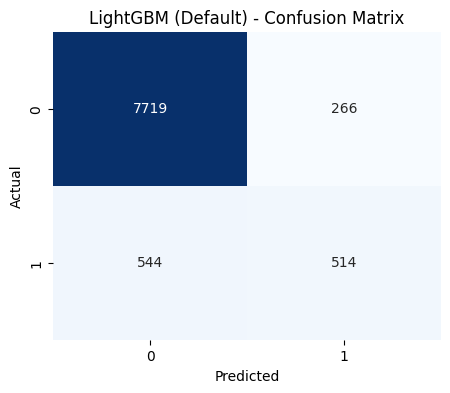

/var/folders/5_/cr0lgx655m7fqg_j4q733qbm0000gn/T/ipykernel_87831/3143478488.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.





상위 10개 중요한 변수:
        feature  importance
11     duration         507
10        month         498
9   day_of_week         368
5       balance         317
0           age         316
13        pdays         256
8       contact         125
12     campaign         115
1           job         105
15     poutcome          88


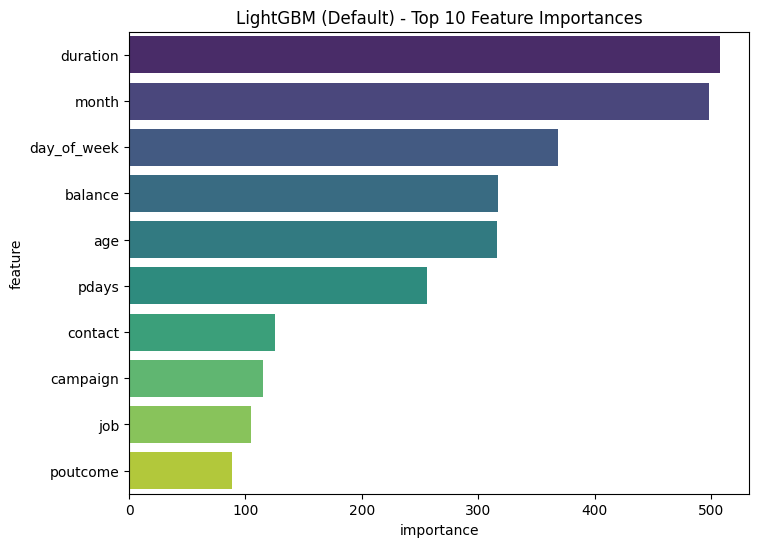


교차검증 결과:
[LightGBM] [Info] Number of positive: 4269, number of negative: 31900
[LightGBM] [Info] Number of positive: 4198, number of negative: 31970
[LightGBM] [Info] Number of positive: 4226, number of negative: 31943
[LightGBM] [Info] Number of positive: 4279, number of negative: 31890
[LightGBM] [Info] Number of positive: 4184, number of negative: 31985
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with featur

KFold (5) AUC: 0.9349 (±0.0058)
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999[LightGBM] [Info] Total Bins 1000

[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] [binary:BoostFromScore]: 

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with featur

StratifiedKFold (5) AUC: 0.9341 (±0.0068)

=== LightGBM (Random Search) ===
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
정확도 (Accuracy): 0.9092
AUC 점수: 0.9333

분류 리포트:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.65      0.48      0.56      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.72      0.75      9043
weighted avg       0.90      0.91      0.90      

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



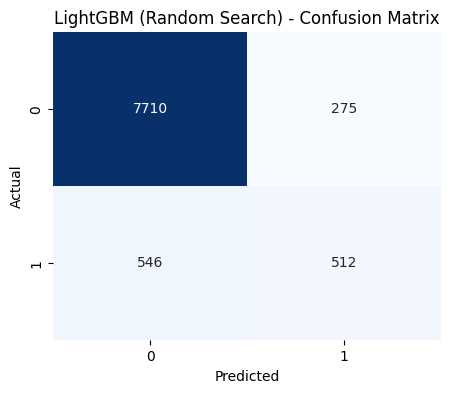


상위 10개 중요한 변수:
        feature  importance
11     duration        1317
10        month        1242
9   day_of_week        1127
0           age        1099
5       balance        1085
13        pdays         805
1           job         404
12     campaign         391
8       contact         292
15     poutcome         247


/var/folders/5_/cr0lgx655m7fqg_j4q733qbm0000gn/T/ipykernel_87831/3143478488.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




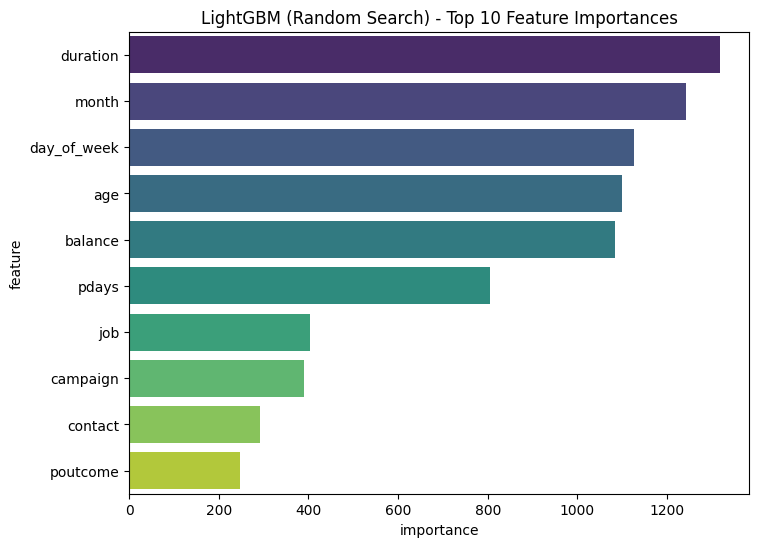


교차검증 결과:
[LightGBM] [Info] Number of positive: 4198, number of negative: 31970
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of positive: 4269, number of negative: 31900
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of positive: 4184, number of negative: 31985
[LightGBM] [Info] Number of positive: 4279, number of negative: 31890
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116069 -> initscore=-2.030190
[LightGBM] [Info] Start training from score -2.030190
[LightGBM] [Info] Number of positive: 4226, number of negative: 31943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010871 seconds.
You can set `force_row_wise=true` to remove the ov

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with featur

KFold (5) AUC: 0.9352 (±0.0060)
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightG

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with featur

StratifiedKFold (5) AUC: 0.9356 (±0.0065)

=== LightGBM (Optuna) ===
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



정확도 (Accuracy): 0.9095
AUC 점수: 0.9330

분류 리포트:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.66      0.47      0.55      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.72      0.75      9043
weighted avg       0.90      0.91      0.90      9043

혼동 행렬:
[[7732  253]
 [ 565  493]]


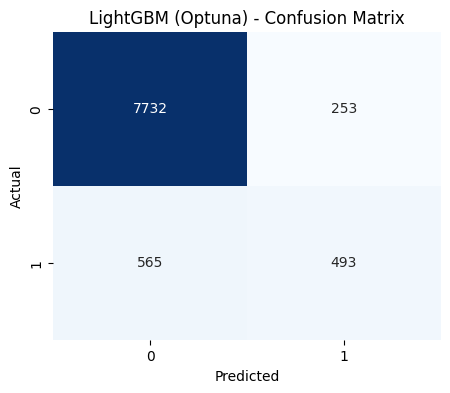


상위 10개 중요한 변수:
        feature  importance
10        month        1088
11     duration         814
9   day_of_week         773
5       balance         552
0           age         543
13        pdays         518
8       contact         278
12     campaign         221
6       housing         186
15     poutcome         185


/var/folders/5_/cr0lgx655m7fqg_j4q733qbm0000gn/T/ipykernel_87831/3143478488.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




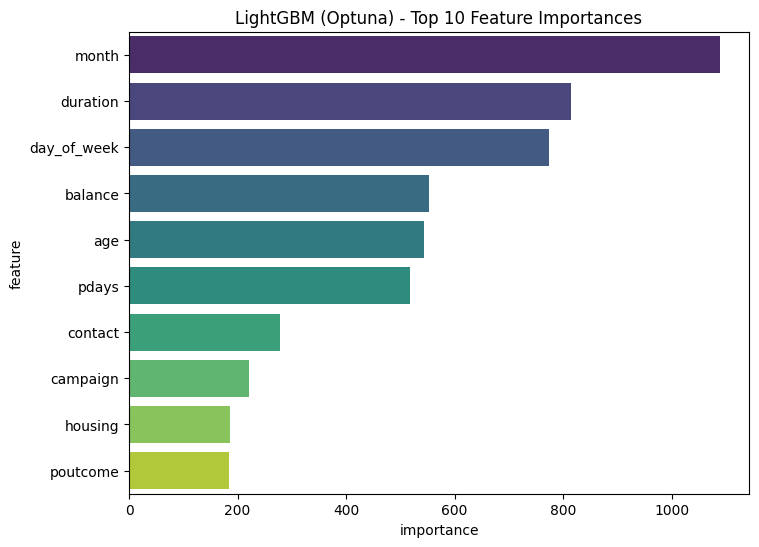


교차검증 결과:
[LightGBM] [Info] Number of positive: 4198, number of negative: 31970
[LightGBM] [Info] Number of positive: 4279, number of negative: 31890
[LightGBM] [Info] Number of positive: 4184, number of negative: 31985
[LightGBM] [Info] Number of positive: 4269, number of negative: 31900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116069 -> initscore=-2.030190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Start training from score -2.030190
[LightGBM] [Info] Number of 

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with featur

KFold (5) AUC: 0.9349 (±0.0056)
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightG

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


StratifiedKFold (5) AUC: 0.9348 (±0.0066)


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# ==========================
# 7. 최적 모델 평가 및 시각화 
# ==========================

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_and_visualize(model, scaler, X, y, title="Model Evaluation"):
    print(f"\n=== {title} ===")
    
    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scaling
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 모델 학습
    model.fit(X_train_scaled, y_train)

    # 예측
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # 성능 평가
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"정확도 (Accuracy): {acc:.4f}")
    print(f"AUC 점수: {auc:.4f}\n")
    print("분류 리포트:")
    print(classification_report(y_test, y_pred))
    print("혼동 행렬:")
    print(confusion_matrix(y_test, y_pred))

    # 혼동 행렬 시각화
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Feature Importance
    feature_importance = pd.DataFrame({
        "feature": X.columns,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)

    print("\n상위 10개 중요한 변수:")
    print(feature_importance.head(10))

    # Feature Importance 시각화
    plt.figure(figsize=(8,6))
    sns.barplot(x="importance", y="feature", data=feature_importance.head(10), palette="viridis")
    plt.title(f"{title} - Top 10 Feature Importances")
    plt.show()

    # ==========================
    # 교차검증 (KFold / StratifiedKFold)
    # ==========================
    print("\n교차검증 결과:")
    X_scaled = scaler.fit_transform(X)  # 전체 데이터 스케일링
    
    cv_strategies = {
        "KFold (5)": KFold(n_splits=5, shuffle=True, random_state=42),
        "StratifiedKFold (5)": StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    }
    
    for name, cv in cv_strategies.items():
        scores = cross_val_score(model, X_scaled, y, cv=cv, scoring="roc_auc", n_jobs=-1)
        print(f"{name} AUC: {scores.mean():.4f} (±{scores.std()*2:.4f})")

    return acc, auc, feature_importance


# ==========================
# 7-0. 기본 LightGBM 모델 평가
# ==========================
default_lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    random_state=42
)
scaler_default = StandardScaler()

acc_default, auc_default, feat_default = evaluate_and_visualize(
    default_lgbm, scaler_default, X_processed, y_processed,
    title="LightGBM (Default)"
)

# ==========================
# 7-1. Random Search 결과 모델 평가
# ==========================
acc_random, auc_random, feat_random = evaluate_and_visualize(
    best_estimator_random, scaler_random, X_processed, y_processed,
    title="LightGBM (Random Search)"
)

# ==========================
# 7-2. Optuna 결과 모델 평가
# ==========================
best_lgbm_optuna = LGBMClassifier(**best_params_optuna, random_state=42)
scaler_optuna = StandardScaler()

acc_optuna, auc_optuna, feat_optuna = evaluate_and_visualize(
    best_lgbm_optuna, scaler_optuna, X_processed, y_processed,
    title="LightGBM (Optuna)"
)



1. 기본 LightGBM
- 정확도 (0.9104)
    전체적으로 91%를 맞혔다는 의미이지만, 데이터의 불균형(클래스 0: 7985 vs 클래스 1: 1058)을 고려하면 “정상 고객만 맞히고 끝”이라도 높은 정확도가 나올 수 있다. 따라서 이 정확도는 모델이 실제로 소수 클래스(마케팅 캠페인에 응답한 고객)를 잘 분류했다고 보장하지 않는다.
- AUC (0.9334)
    ROC-AUC가 높게 나온 것은 임계치(threshold)를 다양하게 바꾸어도 양성과 음성을 잘 구분하는 경향이 있다는 뜻이다. 즉, threshold를 0.5로 고정했을 때는 recall이 낮지만, threshold를 낮춰주면 더 많은 양성을 검출할 수 있다는 가능성을 보여준다. AUC는 클래스 불균형 상황에서도 비교적 안정적이다.
- 분류 리포트
    - 클래스 0: precision 0.93, recall 0.97 → 정상 고객을 맞히는 능력은 탁월하다.
    - 클래스 1: precision 0.66, recall 0.49 → positive 클래스의 절반 이상을 놓치고 있으며, 맞힌 경우에도 34% 정도는 false positive다. 즉 recall이 낮아 “실제 캠페인에 응답한 고객”을 많이 놓치고 있다.
    - macro f1-score가 0.75로 떨어진 이유가 바로 이 클래스 불균형 때문이다.
- 혼동 행렬
    [[7719  266]
     [ 544  514]]
    - TN=7719, FP=266, FN=544, TP=514.
    - FP보다 FN이 많다는 건, 실제 양성 고객을 놓치는 경우가 더 많다는 뜻이다.
    - 마케팅에서는 recall이 중요한 경우가 많다. 응답 고객을 놓치면 매출 기회를 잃기 때문이다.

2. HPO - Random Search
- 정확도 (0.9092)
    기본 모델과 거의 비슷하다. 약간의 튜닝에도 불구하고 정확도 자체는 큰 변화가 없다. 이는 정확도가 불균형 데이터에서 한계가 있음을 다시 보여준다.
- AUC (0.9333) 
    KFold 0.9352, StratifiedKFold 0.9356으로 기본 모델보다 아주 약간 상승했다. threshold를 조정하면서 분류할 때는 기본보다 조금 더 안정적으로 성능을 낼 가능성이 있다.
- 분류 리포트
    - 클래스 0: 여전히 precision과 recall이 0.93, 0.97로 매우 높다.
    - 클래스 1: precision 0.65, recall 0.48로 기본과 사실상 동일하다. 즉 소수 클래스의 검출 능력 개선은 거의 없었다.
    - 이 결과는 Random Search가 탐색한 하이퍼파라미터 범위에서 모델의 capacity가 클래스 1 recall 개선 쪽으로 최적화되지 않았음을 시사한다.
- 혼동 행렬
    [[7710  275]
     [ 546  512]]
    - FN=546, TP=512 → Recall이 낮은 원인은 여전히 많은 FN 때문이다.
    - FP=275로 늘어난 것도 특징인데, precision도 약간 떨어지는 원인이 된다.
    - 따라서 Random Search로 얻은 모델은 recall을 개선하지 못했고, precision과 recall의 균형도 기본과 비슷하다.

3. HPO - Optuna
- 정확도 (0.9095)
    Random Search와 거의 동일하다. 정확도가 유지된다는 건 클래스 불균형 상황에서 정확도 지표만 보는 것이 무의미하다는 점을 다시 보여준다.
- AUC (0.9330)
    KFold 0.9349, StratifiedKFold 0.9348 → 세 모델 중 가장 근소하게 낮지만 사실상 동일한 수준. Optuna가 효율적으로 탐색했지만, 이 데이터셋과 LightGBM에서는 큰 개선을 만들지 못했다.
- 분류 리포트
    - 클래스 1 recall이 0.47로 Random Search(0.48)보다 조금 더 낮아졌다. 즉, 양성을 놓치는 비율이 더 커졌다.
    - precision은 0.66으로 유지되어 “양성이라고 한 경우 2/3는 맞혔다” 수준을 유지.
    - recall이 낮아졌다는 건 Optuna가 찾은 파라미터 조합이 더 보수적으로 분류한 경향이 있다는 뜻이다.
- 혼동 행렬
    [[7732  253]
     [ 565  493]]
    - FN=565, TP=493 → 놓친 양성이 더 많다.
    - FP=253 → 불필요하게 양성이라고 찍은 정상 고객은 줄었지만, 그만큼 recall을 희생한 구조다.
    - 즉 Optuna 모델은 “맞히는 건 좀 더 신중히 하자” 쪽으로 최적화되었다고 볼 수 있다. precision은 유지하면서 recall은 떨어졌다는 점이 이를 보여준다.

# Final Report

- 결과: 3 case 결과 비교 및 해석
  - 정확도
      - 3 case 모두 ~91%로 거의 동일하게 나왔다.
          - 최적화에 따른 정확도 성능 향상이 없었는데 데이터 불균형 상황에선 정확도가 한계적인 지표이기 때문일것으로 생각된다.
  - AUC는 세 모델 모두 ~0.933으로 높다.
      - threshold 조정을 통한 잠재적 구분 능력은 충분하고 생각된다.
  - 분류 리포트와 혼동 행렬을 보면 recall이 공통적으로 낮다.
      - 기본: recall 0.49
      - Random Search: recall 0.48
      - Optuna: recall 0.47
  - 즉, 세 모델 모두 positive 클래스(캠페인 응답 고객)를 제대로 잡아내지 못한다.
  - Random Search vs Optuna의 차이는 precision-recall 균형 방식이다.
      - Random Search는 recall과 precision 모두 기본 모델 수준에서 유지.
      - Optuna는 FP를 줄이는 대신 FN이 늘어 recall을 더 낮췄다.
  - 비즈니스 관점에서는 recall(coverage)이 더 중요하다면 Optuna보다는 Random Search 또는 threshold 조정이 유리하다. 반대로 false positive를 줄이는 게 중요하다면 Optuna 결과를 선호할 수도 있다.